# Calgary Stampeders - Event Propensity MVP
* StellarAlgo Data Science
* Nakisa Rad & Ryan Kazmerik
* May 26, 2022

## Hypothesis
We think that using our Stellar Event Propensity model, we can produce a list of fans that have higher probability to purchase a individual ticket to a game based on their previous purchasing and engagement behaviour.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [2]:
import boto3
import getpass
import pyodbc
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from pycaret.classification import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [4]:
lkupclientid = 35 # stamps
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCFL].[ds].[PropensityEventTraining] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(16924, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16924 entries, 0 to 16923
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysOut              16924 non-null  object        
 1   minDaysOut           16924 non-null  int64         
 2   maxDaysOut           10459 non-null  float64       
 3   dimCustomerMasterId  16924 non-null  int64         
 4   recent_openRate      16924 non-null  float64       
 5   recent_clickRate     16924 non-null  float64       
 6   eventDate            16924 non-null  datetime64[ns]
 7   eventName            16924 non-null  object        
 8   inMarket             14163 non-null  object        
 9   distanceToVenue      14163 non-null  float64       
 10  tenure               16924 non-null  int64         
 11  did_purchase         16924 non-null  int64         
 12  events_purchased     16924 non-null  int64         
 13  frequency_opponent   16924 non-

In [6]:
# choose the features for the stellar base retention model
features = [
                "daysOut",
                #"minDaysOut",
                #"maxDaysOut",
                "dimCustomerMasterId",
                "recent_openRate",
                "recent_clickRate",
                "eventDate",
                #"eventName",
                "inMarket",
                "distanceToVenue",
                "tenure",
                "did_purchase",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventDay",
                "frequency_eventTime"
                #"count_merchOwned"
]

# copy your main dataframe
df_dataset = df

#creating the training and evaluation dataframe
df_dataset = df_dataset[features]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14385, 13)
Unseen Data For Predictions: (2539, 13)



### Now we can model the data using a binary classification prediction for the did_purchase field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId"],
    silent=True,
    verbose=False,
    numeric_features=[
                #"minDaysOut",
               # "maxDaysOut",
                "recent_openRate",
                "recent_clickRate",
                "distanceToVenue",
                "tenure",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventDay",
                "frequency_eventTime"
                #"count_merchOwned"
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["dt", "gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7320,0.8130,0.7078,0.7431,0.7250,0.4639,0.4645,0.0670
gbc,Gradient Boosting Classifier,0.7227,0.8041,0.7013,0.7322,0.7163,0.4454,0.4459,0.2680
xgboost,Extreme Gradient Boosting,0.7218,0.8028,0.7093,0.7269,0.7179,0.4437,0.4439,0.7240
rf,Random Forest Classifier,0.6992,0.7799,0.6836,0.7049,0.6940,0.3983,0.3986,0.2670
lr,Logistic Regression,0.6933,0.7646,0.6595,0.7065,0.6822,0.3865,0.3874,0.1630
dt,Decision Tree Classifier,0.6482,0.6484,0.6392,0.6503,0.6445,0.2964,0.2966,0.3430


In [9]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7310,0.8237,0.7016,0.7443,0.7224,0.4619,0.4627
1,0.7195,0.7994,0.6984,0.7282,0.7130,0.4390,0.4394
2,0.7326,0.8185,0.7066,0.7444,0.7250,0.4652,0.4658
3,0.7326,0.7992,0.7115,0.7419,0.7264,0.4652,0.4656
4,0.7318,0.8243,0.6956,0.7496,0.7216,0.4636,0.4648
5,0.7441,0.8103,0.7234,0.7543,0.7385,0.4881,0.4885
6,0.7367,0.8130,0.7152,0.7470,0.7308,0.4734,0.4738
7,0.7373,0.8162,0.7033,0.7540,0.7277,0.4746,0.4756
8,0.7226,0.8176,0.7016,0.7316,0.7163,0.4451,0.4455
9,0.7316,0.8084,0.7213,0.7358,0.7285,0.4632,0.4632


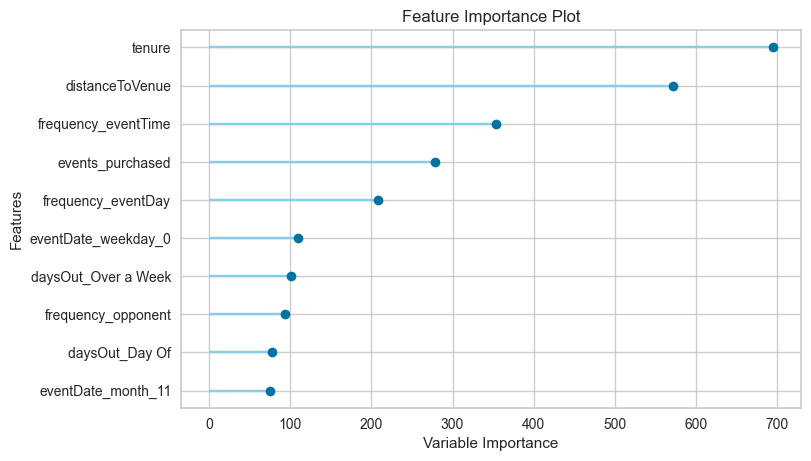

In [10]:
plot_model(final_model, plot='feature')

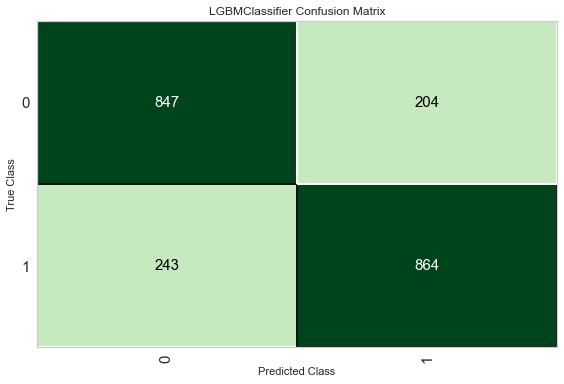

In [11]:
plot_model(final_model, plot='confusion_matrix')

### To connect to RedShift, we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [12]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

MXDN-DCPZ
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


### Now we can create a session and client to RedShift, and create a new connection using Psycopg2:

In [13]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'qa-app'
DBNAME = 'stlrcfl'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: qa-app stlrcfl


### First we need to call the stored procedure, which will create a named cursor - then we can query the results produced by the stored proc using that named cursor to create scoring dataframe:

In [14]:
# create a list of games dates 
game_dates= ['2022-06-09','2022-06-25','2022-07-30','2022-08-13','2022-09-05','2022-09-17','2022-10-01','2022-10-14','2022-10-29']

predictions =[]
for game_date in game_dates:
    
    cur = conn.cursor()
    cur.execute(f"CALL dw.geteventpropensityscoringmodeldata(35, '{game_date}', 'rkcursor')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn.cursor('rkcursor')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df_scoring = pd.DataFrame(data=data, columns=cols)
    df_scoring = df_scoring.fillna(0)
    
    # get predictions from the model for each game
    new_predictions = predict_model(final_model, data=df_scoring, raw_score=True)
    predictions.append(new_predictions)
    
    conn.commit()

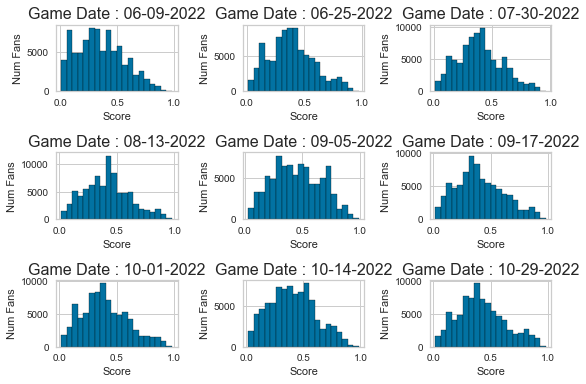

In [15]:

for idx, df_game in enumerate(predictions):    
    
    
    plt.subplot(3, 3, idx+1)

    event_date = df_game['eventDate'].unique()[0].strftime("%m-%d-%Y")

    plt.title("Game Date : " + event_date, fontsize=16)
    plt.xlabel('Score')
    plt.ylabel('Num Fans')
    plt.hist(df_game['Score_1'], bins=20, edgecolor="black")


plt.tight_layout()
plt.show()

In [18]:
for df_game in predictions:
    print(df_game["eventDate"].value_counts().sort_index(ascending=False))

2022-06-09    83720
Name: eventDate, dtype: int64
2022-06-25    83720
Name: eventDate, dtype: int64
2022-07-30    83720
Name: eventDate, dtype: int64
2022-08-13    83720
Name: eventDate, dtype: int64
2022-09-05    83720
Name: eventDate, dtype: int64
2022-09-17    83720
Name: eventDate, dtype: int64
2022-10-01    83720
Name: eventDate, dtype: int64
2022-10-14    83720
Name: eventDate, dtype: int64
2022-10-29    83720
Name: eventDate, dtype: int64


In [17]:
for df_game in predictions:
    print(str(df_game['eventDate'].unique()[0].strftime("%m-%d-%Y")) + '\n' + str(df_game["Score_1"].value_counts(bins=[0, 0.5, 0.8, 1.0])))

06-09-2022
(-0.001, 0.5]    62969
(0.5, 0.8]       19203
(0.8, 1.0]        1548
Name: Score_1, dtype: int64
06-25-2022
(-0.001, 0.5]    60613
(0.5, 0.8]       19731
(0.8, 1.0]        3376
Name: Score_1, dtype: int64
07-30-2022
(-0.001, 0.5]    60773
(0.5, 0.8]       20267
(0.8, 1.0]        2680
Name: Score_1, dtype: int64
08-13-2022
(-0.001, 0.5]    58954
(0.5, 0.8]       21050
(0.8, 1.0]        3716
Name: Score_1, dtype: int64
09-05-2022
(-0.001, 0.5]    49442
(0.5, 0.8]       30585
(0.8, 1.0]        3693
Name: Score_1, dtype: int64
09-17-2022
(-0.001, 0.5]    57628
(0.5, 0.8]       21825
(0.8, 1.0]        4267
Name: Score_1, dtype: int64
10-01-2022
(-0.001, 0.5]    59640
(0.5, 0.8]       20542
(0.8, 1.0]        3538
Name: Score_1, dtype: int64
10-14-2022
(-0.001, 0.5]    56120
(0.5, 0.8]       25026
(0.8, 1.0]        2574
Name: Score_1, dtype: int64
10-29-2022
(-0.001, 0.5]    57278
(0.5, 0.8]       21381
(0.8, 1.0]        5061
Name: Score_1, dtype: int64


### Save the results in for each game in a csv file

In [16]:
for df_game in predictions:

    event_date = df_game['eventDate'].unique()[0].strftime("%m-%d-%Y")
    df_game.to_csv(f"results/stamps_ep_scores_{event_date}.csv", index=False)

## Observations

1. How accurate was this model? 
* The accuracy is 72% 

2. How many fans scored over 0.80 for the 2022 season?
* 06-09-2022 : 3,806 out of 83720
* 06-25-2022 : 5,336 out of 83720
* 07-30-2022 : 5,717 out of 83720
* 08-13-2022 : 7,202 out of 83720
* 09-05-2022 : 6,940 out of 83720
* 09-17-2022 : 3,288 out of 83720
* 10-01-2022 : 8,273 out of 83720
* 10-14-2022 : 5,503 out of 83720
* 10-29-2022 : 11,898 out of 83720

3. What were the most important features in making a correct prediction?
* tenure, distanceToVenue, frequency_eventTime are top 3 important features which makes sense.


## Conclusion

Based on our observations above we reccomend using this event propensity model because we get enough number of buyers that have score above 80% for each game that can be useful for Stamps.